 # Neural Network
[![Open In Colab](./images/colab.svg)](https://colab.research.google.com/github/dunnkers/linear-regression-to-neural-networks/blob/master/src/neural-network.ipynb) [![Binder](./images/binder.svg)](https://mybinder.org/v2/gh/dunnkers/linear-regression-to-neural-networks/HEAD?filepath=src%2Fneural-network.ipynb)

Notebook producing the figures in [Linear Regression to Neural Networks](https://dunnkers.com/linear-regression-to-neural-networks). Chapter on **Neural Networks**. We are going to fit a Neural Network model to try and classify some Penguin species data. We are going to produce this plot:

![neural network fit](./images/neural-fit.gif)

Let's go!

<small>For all source files, see [Github repository](https://github.com/dunnkers/linear-regression-to-neural-networks)</small>.

In [1]:
import shutil
import tempfile
from time import time
import warnings
from warnings import filterwarnings

import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython import get_ipython
from IPython.display import HTML, set_matplotlib_formats
from matplotlib.animation import FuncAnimation
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from tqdm.notebook import tqdm

get_ipython().run_line_magic('matplotlib', 'inline')
set_matplotlib_formats('svg')
get_ipython().system('python --version')


Python 3.9.2


In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
filterwarnings('ignore')

 Load Penguin dataset.

In [3]:
data = sns.load_dataset('penguins')
data = data.dropna()
data.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

 Make column for only indicating Chinstrap yes/no.

In [4]:
peng = lambda x: 'Chinstrap' if x == 'Chinstrap' else 'Other'
data['Penguin'] = data['species'].apply(peng)

 Training/testing cross validation split. Reserve 1/4th of data for testing.

In [5]:
rs = np.random.RandomState(34)
test = rs.choice(data.index, len(data) // 4)
train = data.index[~data.index.isin(test)]
data.loc[train, 'subset'] = 'Train'
data.loc[test, 'subset'] = 'Test'
data_train = data[data['subset'] == 'Train']
data_test = data[data['subset'] == 'Test']
data.groupby('subset').count()[['species']]


,species
subset,
Test,78
Train,255


<AxesSubplot:xlabel='bill_depth_mm', ylabel='bill_length_mm'>

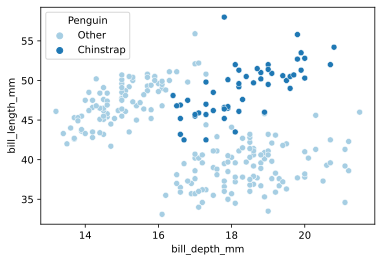

In [6]:
blue_colors = sns.color_palette("Paired", n_colors=2)
sns.scatterplot(data=data_train, x='bill_depth_mm', y='bill_length_mm',
                hue='Penguin', palette=blue_colors)

In [7]:
X       = data[['bill_depth_mm', 'bill_length_mm']].values
X_train = data_train[['bill_depth_mm', 'bill_length_mm']].values
y_train = data_train['Penguin'].values
X_test  = data_test[['bill_depth_mm', 'bill_length_mm']].values
y_test  = data_test['Penguin'].values

 Let's try to classify Chinstraps using a Neural Network. We'll use sklearn for this. Try a fit:

In [8]:
clf = MLPClassifier()
clf.fit(X_train, y_train)
clf.n_iter_, clf.classes_, clf.loss_

(20, array(['Chinstrap', 'Other'], dtype='<U9'), 0.6802473764869513)

 Let's get more systematic. First, we'll do a cross-validation training/testing split.

In [9]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8589743589743589

 Next, we create a function to predict our classifier over a grid points, to be used for plotting our decision regions later.

In [10]:
def apply_over_grid(X, clf, *args):
    xaxis = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    yaxis = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    xx, yy = np.meshgrid(xaxis, yaxis)
    zz = np.dstack([xx, yy])
    ax1, ax2, ax3 = zz.shape
    X = zz.reshape((ax1 * ax2, ax3))
    zz = clf(X, *args)
    zz = zz.reshape((ax1, ax2))
    return xx, yy, zz
xx, yy, zz = apply_over_grid(X, lambda X: X.sum(axis=1))
X.shape, xx.shape, yy.shape, zz.shape


((333, 2), (100, 100), (100, 100), (100, 100))

 Wrap our `clf` object in a predictor variable.

In [11]:
predictor = lambda clf: lambda X: clf.predict_proba(X)[:, 0]
predictor(clf)([[2, 3]])

array([0.16849991])

 Run some couple thousand iterations using our Neural Network. It has a rather 'arbitrary' architecture of 3 layers of 5 nodes each - should be enough to capture the complexity of this dataset.

In [12]:
max_iter = 16
iterations = 2400
n_fits = iterations // max_iter
clf = MLPClassifier(
    hidden_layer_sizes=(5, 5, 5),
    alpha=0.0005,
    learning_rate_init=0.001,
    max_iter=max_iter,
    n_iter_no_change=max_iter,
    random_state=33,
    tol=1e-15,
    warm_start=True,
    solver='sgd',
    learning_rate='adaptive'
)

records = []
zzz = []
pbar = tqdm(range(n_fits))
iters = 0
for i in pbar:
    clf.fit(X_train, y_train)
    record = { 'Loss': clf.loss_, 'Iteration': clf.n_iter_, 'i': i }
    acc = clf.score(X_train, y_train)
    records.append({ **record, 'Acc': acc, 'Subset': 'Train' })
    acc = clf.score(X_test, y_test)
    records.append({ **record, 'Acc': acc, 'Subset': 'Test' })
    
    _, _, zz = apply_over_grid(X, predictor(clf))
    zzz.append(zz)
    pbar.set_description(f'n_iter={clf.n_iter_}')


  0%|          | 0/150 [00:00<?, ?it/s]

 Collect results in a DataFrame and plot loss and accuracy.

<AxesSubplot:xlabel='Iteration', ylabel='Loss'>

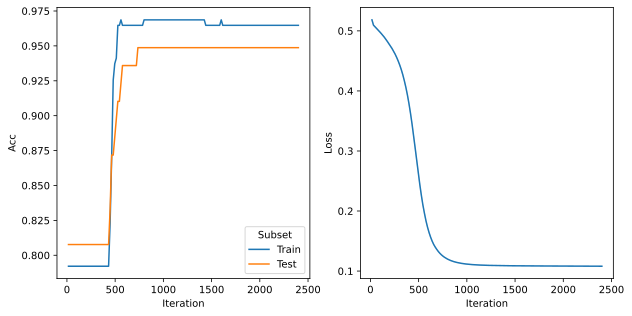

In [13]:
results = pd.DataFrame.from_records(records, index='i')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(data=results, x='Iteration', y='Acc', hue='Subset', ax=ax1)
sns.lineplot(data=results, x='Iteration', y='Loss', ax=ax2)

 Plot decision region of last fit.

Text(0.5, 1.0, 'train (⚫︎)=232, test (×)=2324')

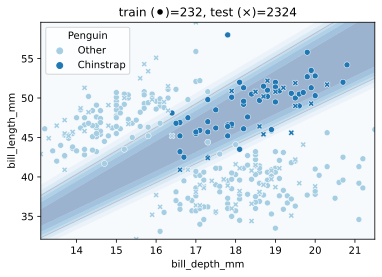

In [14]:
def decision_region(ax, zz):
    plt.contourf(xx, yy, zz, alpha=0.8,
                           levels=[0.495, 0.505], colors=['red'])
    plt.contourf(xx, yy, zz, alpha=0.4, cmap='Blues')
    sns.scatterplot(data=data_train, x='bill_depth_mm', y='bill_length_mm',
                    hue='Penguin', palette=blue_colors, ax=ax)
    sns.scatterplot(data=data_test, x='bill_depth_mm', y='bill_length_mm',
                    hue='Penguin', palette=blue_colors, ax=ax,
                    style='subset', style_order=['Train', 'Test'],
                    legend=False)
    
fig = plt.figure()
ax = fig.gca()
decision_region(ax, zzz[-1])
plt.title(f'train (⚫︎)=232, test (×)=2324')

 We are going to create a range of images. Create a temporary folder for them.

In [15]:
folder = tempfile.mkdtemp()
print(f'Saving images to {folder}')

Saving images to /var/folders/34/923qqr696yz_ybx0dl171fn80000gn/T/tmpxvaqahu8


In [16]:
frames = 150
assert(frames <= n_fits)
interval = n_fits // frames
idxs = np.arange(frames - 1) * interval
idxs = np.append(n_fits - 1, idxs)
f'{n_fits} fits, {frames} frames; interval of {interval}. Start at {idxs[0]}.'

'150 fits, 150 frames; interval of 1. Start at 149.'

 Compute and save separate GIF images.

  0%|          | 0/150 [00:00<?, ?it/s]

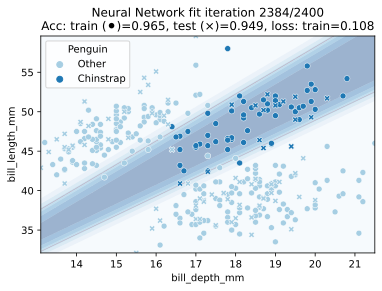

In [17]:
pbar = tqdm(total=frames)
def create_frame(frame, ax, zzz):
    ax.cla()

    i = idxs[frame]

    # decision region
    decision_region(ax, zzz[i])

    # plot title
    result = results[results.index == i]
    trn = result[result['Subset'] == 'Train']
    tst = result[result['Subset'] == 'Test']
    loss = result['Loss'].unique().item()
    acc, acc_test = trn['Acc'].item(), tst['Acc'].item()
    iteration = result['Iteration'].unique().item()
    plt.title(f'Neural Network fit iteration {iteration:04}/{iterations}\n'+
              f'Acc: train (⚫︎)={acc:.3f}, test (×)={acc_test:.3f}, '+
              f'loss: train={loss:.3f}')
    plt.savefig(f'{folder}/frame_{frame:03}.png')

    # progress bar
    pbar.update()
    
fig = plt.figure()
ax = fig.gca()
animation = FuncAnimation(fig, create_frame,
    frames=frames, fargs=(ax, zzz), interval=100) # => 10 fps
animated = animation.to_jshtml()
pbar.close()

Convert separate images into a GIF.

In [18]:
name = './images/neural-fit.gif'
get_ipython().system('convert -background white -alpha remove '+
    '-dispose Previous +antialias -layers OptimizePlus '+
    f'{folder}/*.png {name}')

Clean the temporary folder 💎

In [19]:
shutil.rmtree(folder)

### Author
[Code](https://github.com/dunnkers/linear-regression-to-neural-networks) written by [Jeroen Overschie](https://dunnkers.com). MIT licensed.